In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

# Quantitative Response

# David Aponte




# Introduction

In this notebook I will participate in a Kaggle competition and use their bike sharing dataset to predict the number of bike rentals per hour. The task a regression problem - a quantitative response. The goal is develop a simple, yet flexible model that can produce relatively good results. To gauge how well my model would perform with unseen observations I will submit my predictions to the Kaggle website, to be automatically scored and ranked using their private test set. 

# Agenda

- Preprocessing
- EDA
- Feature Engineering
- Baseline
- Feature Generation
- Modeling
- Model Selection
- Hyperparameter Tuning

# Data Overview

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

I have been provided with hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. The goal is to predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period. In the training data set, they have separately given bike demand by registered, casual users and sum of both is given as count.

#### Data Source: https://www.kaggle.com/c/bike-sharing-demand/data

# Data Fields

- <code>datetime</code> - hourly date + timestamp
- <code>season</code> - 1 = spring, 2 = summer, 3 = fall, 4 = winter
- <code>holiday</code> - whether the day is considered a holiday
- <code>workingday</code> - whether the day is neither a weekend nor holiday
- <code>weather</code> -
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- <code>temp</code> - temperature in Celsius
- <code>atemp</code> - "feels like" temperature in Celsius
- <code>humidity</code> - relative humidity
- <code>windspeed</code> - wind speed
- <code>casual</code> - number of non-registered user rentals initiated
- <code>registered</code> - number of registered user rentals initiated
- <code>count</code> - number of total rentals (Dependent Variable)

# Goal

The goal is to predict a quantitative response (counts), making this a regression problem.



In [2]:
train_df = pd.read_csv("train_bike_sharing.csv")
test_df = pd.read_csv("test_bike_sharing.csv")

### Preview

First things first. Lets get some information about the train and the test set. 

In [3]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.6+ KB


In [7]:
print(train_df.shape)
print(test_df.shape)

(10886, 12)
(6493, 9)


# Preprocessing

This dataset first needs to be preprocessed a bit before we conduct EDA. This was inspired by ChristophM and his work on interpretable machine learning and Vivek Srinivasan's kernel on kaggle. The following will be done:

- Convert categorical features to pandas categorical type.
- Create new features from <code>datetime</code>.
- Map words to <code>season</code> feature.
- Map words to <code>weather</code>
- Map words to <code>workingday</code>
- Map words to <code>holiday</code>

First well create the new date features from datetime, map the words to integers, and convert them all to categorical type.

In [8]:
# create function to preprocess features

def preprocess(train_df):
    """
    This function preprocesses the training data for EDA purposes.
    """
    
    # create copies
    train = train_df.copy()
    
    
    # date
    train['date'] = train['datetime'].apply(lambda x: x.split()[0])
    # month 
    train['month'] = train['date'].apply(lambda x: calendar.month_name[datetime.strptime(x, "%Y-%m-%d").month])
    # weekday
    train['weekday'] = train['date'].apply(lambda x: calendar.day_name[datetime.strptime(x, "%Y-%m-%d").weekday()])
    # hour
    train['hour'] = train['datetime'].apply(lambda x: x.split()[1].split(":")[0])
    # season
    train['season'] = train['season'].map({1: "Spring",
                                          2: "Summer",
                                          3: "Fall",
                                          4: "Winter"})
    # weather
    train['weather'] = train['weather'].map({1: "Clear + Few clouds + Partly cloudy + Partly cloudy",
                                            2: "Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",
                                            3: "Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds",
                                            4: "Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog"})
    # holiday
    train['holiday'] = train['holiday'].map({1: "Holiday",
                                            0: "No Holiday"})
    # working day
    train['workingday'] = train['workingday'].map({1: "Workingday",
                                                   0: "No Workingday"})
    # drop datetime
    train.drop('datetime', axis=1, inplace=True)
    
    # convert to categorical type
    cat_features = ['workingday', 'holiday', 'weather', 'season', 'hour', 'weekday', 'month', 'date']
    train[cat_features] = train[cat_features].astype('category')
    return train

train_ = preprocess(train_df)

In [9]:
train_.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,month,weekday,hour
0,Spring,No Holiday,No Workingday,Clear + Few clouds + Partly cloudy + Partly cl...,9.84,14.395,81,0.0,3,13,16,2011-01-01,January,Saturday,00
1,Spring,No Holiday,No Workingday,Clear + Few clouds + Partly cloudy + Partly cl...,9.02,13.635,80,0.0,8,32,40,2011-01-01,January,Saturday,01
2,Spring,No Holiday,No Workingday,Clear + Few clouds + Partly cloudy + Partly cl...,9.02,13.635,80,0.0,5,27,32,2011-01-01,January,Saturday,02
3,Spring,No Holiday,No Workingday,Clear + Few clouds + Partly cloudy + Partly cl...,9.84,14.395,75,0.0,3,10,13,2011-01-01,January,Saturday,03
4,Spring,No Holiday,No Workingday,Clear + Few clouds + Partly cloudy + Partly cl...,9.84,14.395,75,0.0,0,1,1,2011-01-01,January,Saturday,04


In [10]:
train_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
season        10886 non-null category
holiday       10886 non-null category
workingday    10886 non-null category
weather       10886 non-null category
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
date          10886 non-null category
month         10886 non-null category
weekday       10886 non-null category
hour          10886 non-null category
dtypes: category(8), float64(3), int64(4)
memory usage: 716.8 KB


# EDA

Now lets get familiar with the data and explore the distributions, looking for insights.

In [11]:
# dtypes
train_.dtypes.value_counts()

int64       4
float64     3
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
dtype: int64

We have 7 numeric features (continuous and discrete) and 8 categorical features (I may use features and variables interchangeably). 

In [12]:
train_.isnull().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
date          0
month         0
weekday       0
hour          0
dtype: int64

The training set has no missing values. Now lets look at the target feature <code>count</code>.

In [13]:
# count
train_['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

C:\ProgramData\Anaconda_apont\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


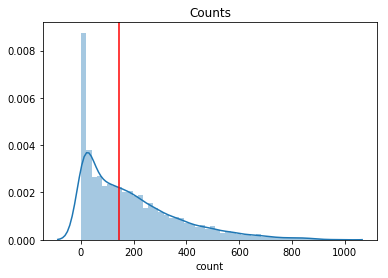

In [14]:
sns.distplot(train_['count'],bins=50)
plt.axvline(train_['count'].median(), c='r')
plt.title("Counts")
plt.show()

There is fairly large amount of variance in the distribution of <code>count</code> as you can see with the mean of 191.57 and a standard deviation of 181.14. The distribution is unimodal and has a right skew. Now lets view the target across some of the categorical variables.

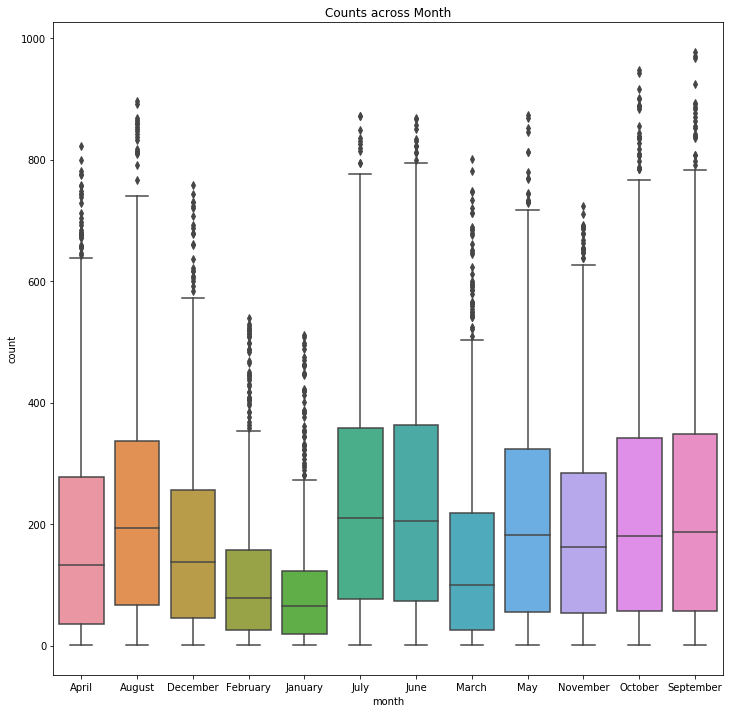

In [15]:
plt.figure(figsize=(12, 12))
sns.boxplot(data=train_, y='count', x='month')
plt.title("Counts across Month")
plt.show()

I see that there are higher counts during the summer and fall months

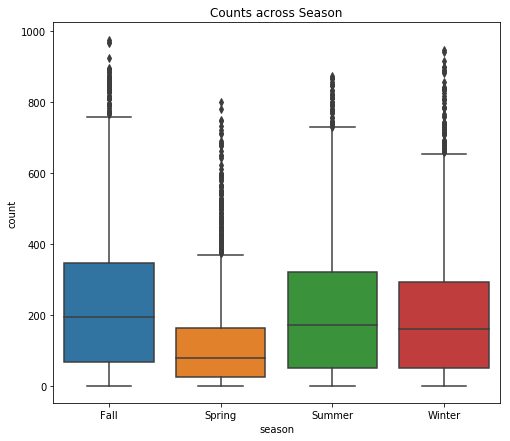

In [16]:
plt.figure(figsize=(8, 7))
sns.boxplot(data=train_, y='count', x='season')
plt.title("Counts across Season")
plt.show()

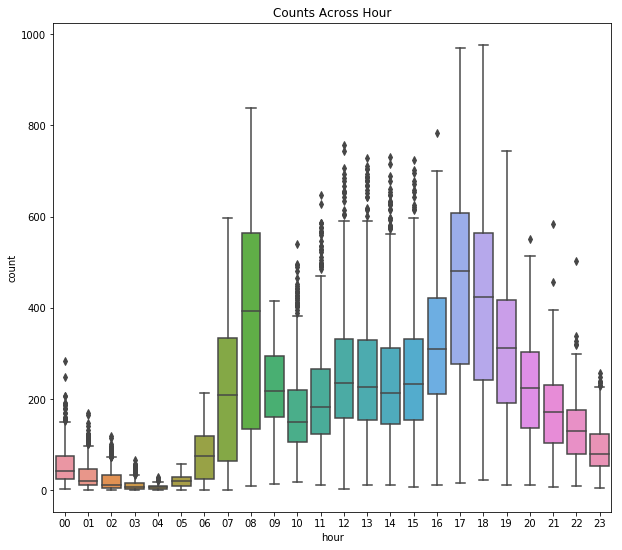

In [17]:
plt.figure(figsize=(10, 9))
sns.boxplot(data=train_, y='count', x='hour')
plt.title("Counts Across Hour")
plt.show()

From this plot you can see that the median counts are highest around 7-8 AM and 5-6 PM. This makes sense since those when people are going to work or school or coming home after work.

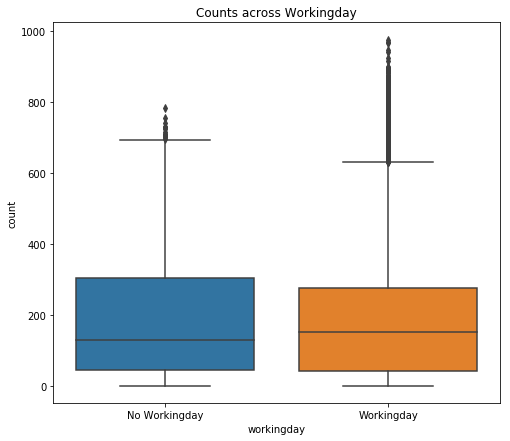

In [18]:
plt.figure(figsize=(8, 7))
sns.boxplot(data=train_, y='count', x='workingday')
plt.title("Counts across Workingday")
plt.show()

Lets now look at how the mean count varies across some of the features. In particular, I want to see how the average counts change across time and some of the other features. This is a good way to view trends in the data. 

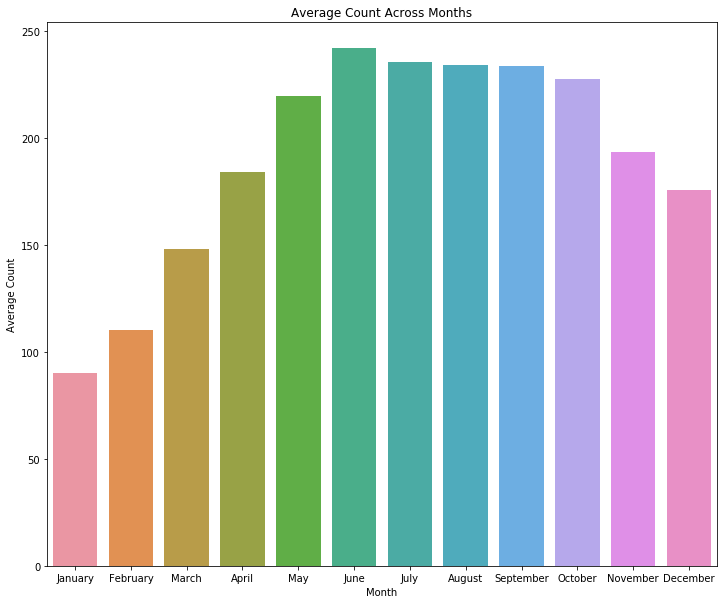

In [19]:
# we need to first order some of the data
months = ["January","February","March","April","May","June","July","August","September","October","November","December"]
days = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
season = ['Winter', 'Spring', 'Summer', 'Fall']

# use groupby 
count_month = train_.groupby("month", as_index=False)['count'].mean()

# use sns.barplot and add order arguement
plt.figure(figsize=(12, 10))
sns.barplot(data = count_month, x='month', y='count', order=months)
plt.title("Average Count Across Months")
plt.ylabel("Average Count")
plt.xlabel("Month")
plt.show()

I definitely see a trend across months. The Summer and Fall months have the highest amount of bike rentals. And this makes sense since a lot of people are riding when the weather is nicer outside. June has the highest amount of rentals.

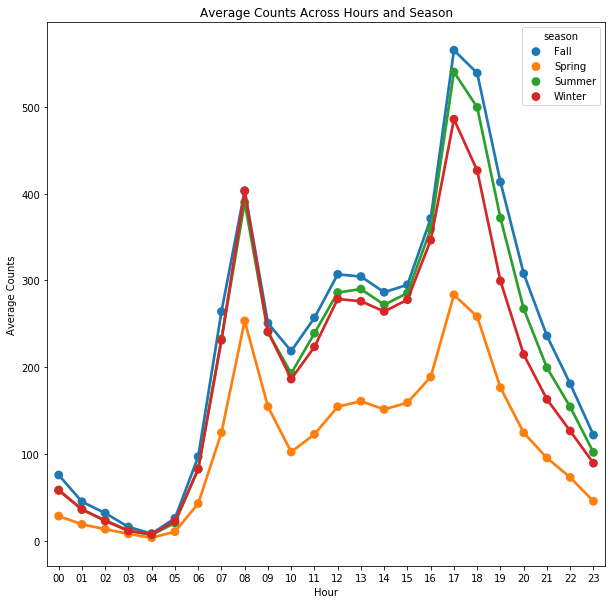

In [20]:
# groupby hour and season
counts_hour_season = train_.groupby(['hour','season'], as_index=False)['count'].mean()

# pointplot
plt.figure(figsize=(10,10))
sns.pointplot(data = counts_hour_season, x = 'hour', y = 'count', hue='season')
plt.title("Average Counts Across Hours and Season")
plt.xlabel("Hour")
plt.ylabel("Average Counts")
plt.show()

There is also a trend across seaons and hours. As stated before, 7-8 AM and 5-6 PM have the highest amount of bike rentals. This also makes sense since those are relatively busy time in Washington D.C. - people going to work or school and then returning around 5-6 PM. 

As seen in the previous plot, we see that Fall and Summer have the most bike rentals. But to my surprise there are a low amount of rentals in the Spring time - less than winter. This is interesting. Having some domain knowledge because I am only a few hours away from Washington D.C - I know that Spring time in this area still has really low temperatures. To test this hypothesis, I will create a pointplot with the average temperature across hours and seasons.

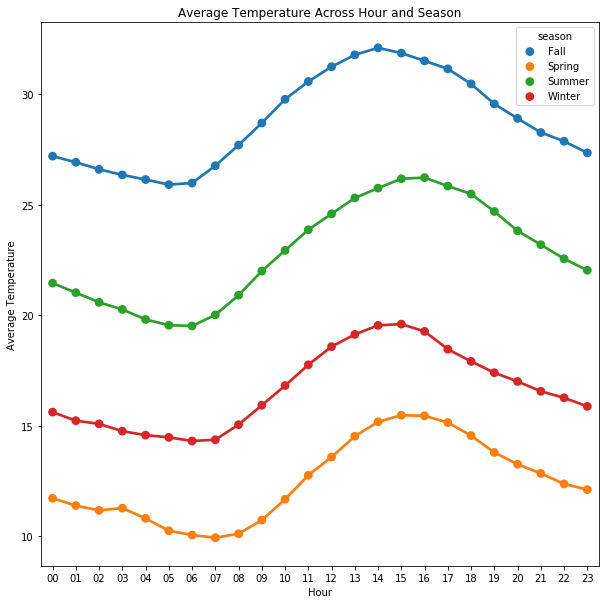

In [21]:
# get average temp instead
count_temp_hour_season = train_.groupby(['hour','season'], as_index=False)['temp'].mean()

plt.figure(figsize=(10,10))
sns.pointplot(data = count_temp_hour_season, x = 'hour', y = 'temp', hue='season')
plt.title("Average Temperature Across Hour and Season")
plt.xlabel("Hour")
plt.ylabel("Average Temperature")
plt.show()

As you can see from the plot above, that the spring time has the lowest average temperature. This confirms my hypothesis as to why there are lower counts of bike rentals in the spring. We may be able to use this information to create new features later on.

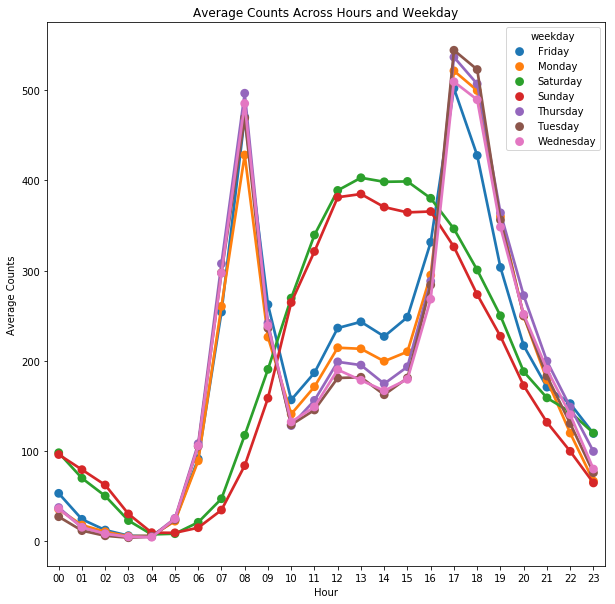

In [22]:
# groupby hour and weekday
counts_hour_day = train_.groupby(['hour','weekday'], as_index=False)['count'].mean()

# pointplot
plt.figure(figsize=(10,10))
sns.pointplot(data = counts_hour_day, x = 'hour', y = 'count', hue='weekday')
plt.title("Average Counts Across Hours and Weekday")
plt.xlabel("Hour")
plt.ylabel("Average Counts")
plt.show()

This plot has some interesting findings as well. For example, I notice two different trends - one for the weekdays and one for the weekends. The weekends (Saturday and Sunday) have a bell shaped trend that peaks around 1-4 PM. This also makes since people tend to wake up later on the weekends and usually arent in as much of rush. You can sort of see this rush with the steeper slopes found in the weekday days - around 7-8 AM and 5-6 PM you have sharp increases in rentals that later on decreases. Compare that to the weekend trend which is low in the earlier hours and higher during afternoon - also, the increase in rentals is a bit slower and steader when compared to the sharp increase and decrease found during the work week (Monday through Friday). These findings make sense since people tend to be in a bigger rush during the week getting to work and school and probably are taking there time during the weekends when they're off from work.

Now I want to see if there are some differences between users that are casual riders or registered users.

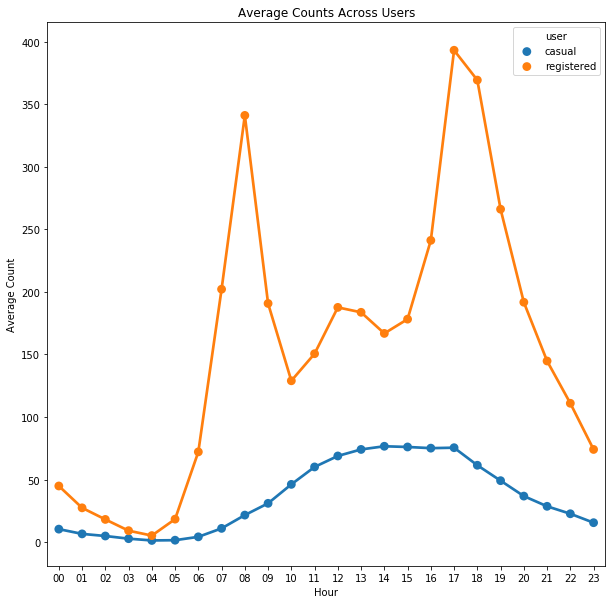

In [23]:
# instead of a groupby well need to use the melt function
melted_df = pd.melt(train_[["hour","casual","registered"]], id_vars=['hour'], value_vars=["casual", "registered"], value_name='count', var_name='user')
count_hour_user = melted_df.groupby(['hour', 'user'], as_index=False)['count'].mean()

plt.figure(figsize=(10,10))
sns.pointplot(data = count_hour_user, x = 'hour', y = 'count', hue='user')
plt.title("Average Counts Across Users")
plt.ylabel("Average Count")
plt.xlabel("Hour")
plt.show()

In this plot you can clearly see a difference between rentals by casual users and registered users. I would hypothesize based off this plot that registered users have sharper increases in rentals because many of them are commuters. Alternatively, the casual users have a "rounder", less drastic trend that may be due to the fact that they usually rent their bikes without rushing to some place.

Its usually a good idea to remove outliers in the target feature by clipping them. I will use a winsorization technique - clipping the counts between a lower and upper bound. 

In [24]:
lowerbound, upperbound = np.percentile(train_['count'], [0,99])
train_['count_clipped'] = np.clip(train_['count'], upperbound, lowerbound)
train_['count_clipped'].describe()

count    10886.000000
mean       190.914693
std        178.833463
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        774.150000
Name: count_clipped, dtype: float64

C:\ProgramData\Anaconda_apont\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


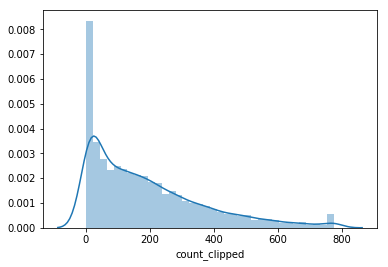

In [25]:
sns.distplot(train_['count_clipped'])
plt.show()

Another idea would be to transform the target - e.g. log transformation. Well confirm which method to use before modeling.

C:\ProgramData\Anaconda_apont\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


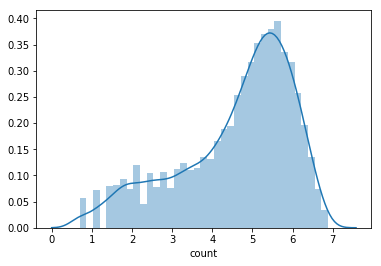

In [26]:
sns.distplot(np.log1p(train_['count']))
plt.show()

Now lets see the correlations within the dataset. There may be collinearity.

In [27]:
corrs = train_[['temp', 'atemp', 'casual', 'registered', 'humidity', 'windspeed', 'count']].corr()
corrs

,temp,atemp,casual,registered,humidity,windspeed,count
temp,1.000000,0.984948,0.467097,0.318571,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,0.462067,0.314635,-0.043536,-0.057473,0.389784
casual,0.467097,0.462067,1.000000,0.497250,-0.348187,0.092276,0.690414
registered,0.318571,0.314635,0.497250,1.000000,-0.265458,0.091052,0.970948
humidity,-0.064949,-0.043536,-0.348187,-0.265458,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,0.092276,0.091052,-0.318607,1.000000,0.101369
count,0.394454,0.389784,0.690414,0.970948,-0.317371,0.101369,1.000000


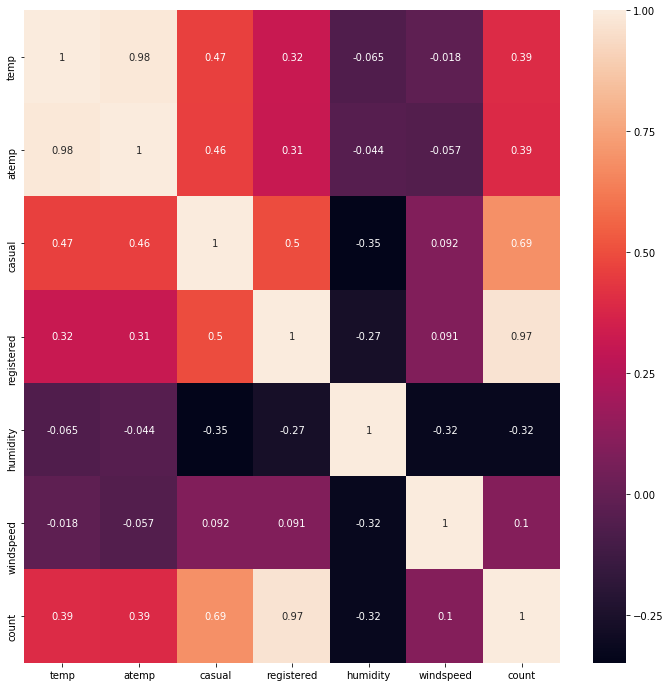

In [28]:
plt.figure(figsize=(12,12))
sns.heatmap(corrs,annot=True)
plt.show()

### Correlations with the target 

From the correlation matrix we can see there are some features correlated with the target: 

- temp, atemp, casual, and registered all have positive correlations with the target.
- humidity has a negative correlation with the target.

### Multicollinearity

There are also some features correlated to each other:

- temp and atemp are highly correlated to each other. This can be a problem for modeling later on so we might consider dropping one of them.
- casual and registed contain information about the target so it is expected that there is some correlation between themselves and between them and the target. We may consider dropping these variables during modeling.

Lets take a closer look at the correlations between temp, humidity and windspeed.

C:\ProgramData\Anaconda_apont\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


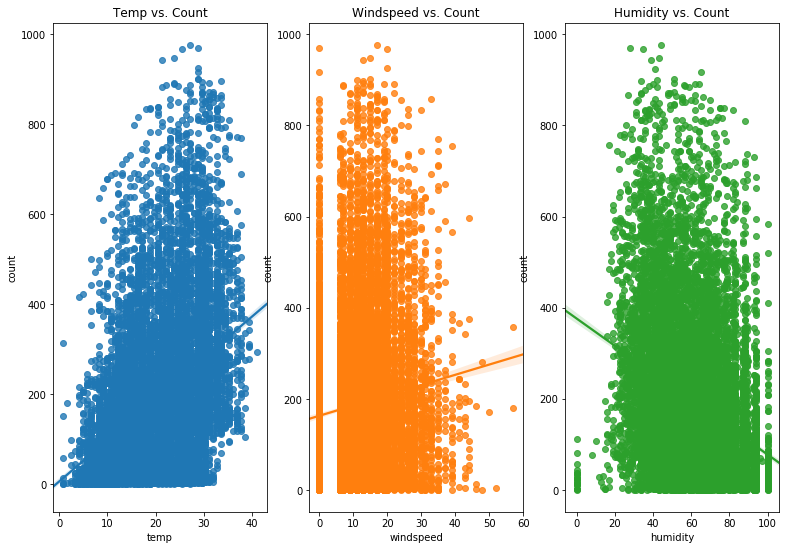

In [29]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(13, 9)
sns.regplot(x = train_['temp'], y = train_['count'], ax=ax1)
sns.regplot(x = train_['windspeed'], y = train_['count'], ax=ax2)
sns.regplot(x = train_['humidity'], y = train_['count'], ax=ax3)
ax1.set_title("Temp vs. Count")
ax2.set_title("Windspeed vs. Count")
ax3.set_title("Humidity vs. Count")
plt.show()

### Missing Values

It turns out that the windspeed plays an important role in predicting the number of bike rentals. Looking at Kaggle kernels and discussions I found that zeros in the windspeed feature represent missing values. Therefore, if we want to use it as a feature we need to impute it with a value. While I would normally impute it with either the mean or the median (or if I have more information, in other creative ways) I am going to follow ChristophM who used a Random Forest Regressor to predict the missing values. 

In [30]:
train_['windspeed'].describe()

count    10886.000000
mean        12.799395
std          8.164537
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64

C:\ProgramData\Anaconda_apont\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


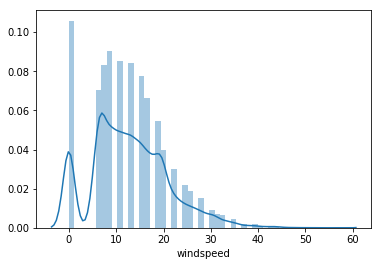

In [31]:
sns.distplot(train_['windspeed'])

# Feature Engineering

- Looking at the distribution you can see that a theres a spike in 0 values. This confirms what I found - that 0's represent missing values. In order to deal with this I will seperate the dataset into observations with a <code>windspeed_zero</code> and a <code>windspeed_not_zero</code>. I will train the RandomForestRegressor with data containing non-zero values and make predictions using the data containing zero values.

- We first need to preprocess the features similarly to the way I did before conducting EDA but this time without mapping words to some of the integer features (e.g. workday).

- Since the data provided by the organizers was a train (train_df) and test (test_df) set split by time, we will need to feature engineer the features appropriately. In order to impute the missing values I'll combine both of the datasets, but afterwards I will resplit them according to the observations - observations containing null values for <code>count</code> will be the test set and the remaining observations of the combined dataset will be the training set.

In [32]:
# preprocess for feature engineering
def preprocess_for_engineering(train, test):
    """
    This function preprocesses the data for further feature
    engineering.
    """
    # we first need to combine train and test
    df = train_df.append(test_df)
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)
    
    # date
    df['date'] = df['datetime'].apply(lambda x: x.split()[0])
    # month 
    df['month'] = df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").month)
    # year
    df["year"] = df['datetime'].apply(lambda x : x.split()[0].split("-")[0])
    # weekday
    df['weekday'] = df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").weekday())
    # hour
    df['hour'] = df['datetime'].apply(lambda x: x.split()[1].split(":")[0]).astype('int')
    
    # convert to category type
    cat_features = ['holiday', 'weather', 'season', 'hour', 'weekday', 'month', 'year']
    df[cat_features] = df[cat_features].astype('category')
    
    # split
    # training data
    train = df[pd.notnull(df['count'])].sort_values(by='datetime')
    # test data
    test = df[~pd.notnull(df['count'])].sort_values(by='datetime')
    
    del df
    
    
    return train, test

# verify
tr, te = preprocess_for_engineering(train_df, test_df)

C:\ProgramData\Anaconda_apont\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [33]:
# verify
tr.head()

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday,date,month,year,weekday,hour
0,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0,2011-01-01,1,2011,5,0
1,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0,2011-01-01,1,2011,5,1
2,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0,2011-01-01,1,2011,5,2
3,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0,2011-01-01,1,2011,5,3
4,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0,2011-01-01,1,2011,5,4


### Predicting Windspeed Missing Values

Now I want to seperate the data into two subsets (<code>windspeed_zero</code> and <code>windspeed_not_zero</code>) and then train a Random Forest Regressor using <code>windspeed_not_zero</code> and make predictions using  <code>windspeed_zero</code>.

In [34]:
def impute_rf(train, test):
    """
    This function imputes the missing values for 'windspeed'
    """
    
    from sklearn.ensemble import RandomForestRegressor
    
    # we first need to combine train and test
    df = train.append(test)
    from sklearn.ensemble import RandomForestRegressor

    # null values
    windspeed_zero = df[df['windspeed'] == 0]
    # non-null values
    windspeed_not_zero = df[df['windspeed'] != 0]
     
    rf_imputer = RandomForestRegressor()
    # subset of columns for training
    subset = ["season","weather","humidity","month","temp","year","atemp"]
    # fit model
    rf_imputer.fit(windspeed_not_zero[subset], windspeed_not_zero['windspeed'])
    # predict
    windspeed_preds = rf_imputer.predict(windspeed_zero[subset])
    # replace zeros with predictions
    windspeed_zero['windspeed'] = windspeed_preds

    # recombine data
    data = windspeed_not_zero.append(windspeed_zero)
    # reset index
    data.reset_index(inplace=True)
    # drop index
    data.drop('index', axis=1, inplace=True)
    
    # training data
    train = data[pd.notnull(data['count'])].sort_values(by='datetime')
    # test data
    test = data[~pd.notnull(data['count'])].sort_values(by='datetime')
    
    # clear up space
    del df
    del data
    
    return train, test
    
    
    
tr, te = impute_rf(tr, te)  

C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda_apont\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


C:\ProgramData\Anaconda_apont\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


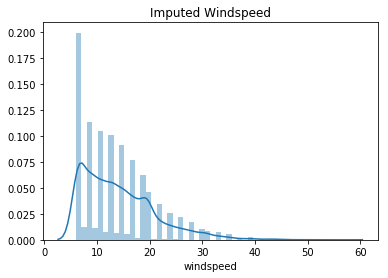

In [35]:
# verify distribution of windspeed
sns.distplot(tr['windspeed'])
plt.title("Imputed Windspeed")
plt.show()

In [36]:
# summary stats
tr['windspeed'].describe()

count    10886.000000
mean        14.092950
std          6.926201
min          6.003200
25%          8.998100
50%         12.998000
75%         19.001200
max         56.996900
Name: windspeed, dtype: float64

### Validation Approach

It was stated earlier but I'll repeat it once more: the data is sequential, and therefore, the observations are not independent of each other. We confirmed this with some plots during the EDA phase. As the organizers split the data by time, so will we. We first need to sort the data by <code>datetime</code> and then split the data by those observations containing null values for the target variable <code>count</code> and those that have non-null values. The data was given to us this way (a train and test set) but since we combined it for preprocessing purposes we need to resplit the data once more. 

Stated formally, our validation approach will be a simple holdout method. We will set aside a series of observations (test) during prediction time to evaluate the performance of our model on unseen data. Our model selection will be done on the training set and our final predictions will be made using the test set.

Keeping in line with the data organizers and the Kaggle competition, we will be using RMSLE as our evaluation metric. We will choose the model that has the best test set score. 


In [37]:
# combined
data = tr.append(te)

# training data
X_train = data[pd.notnull(data['count'])].sort_values(by='datetime')
# test data
X_test = data[~pd.notnull(data['count'])].sort_values(by='datetime')
# set up target vectors
y_train = X_train['count']

# dimensions should be equal to original train and test data
print(X_train.shape, X_test.shape, "Train and Test features")
print(y_train.shape, "Train labels")

# check
assert X_train.shape[0] == train_df.shape[0]
assert X_test.shape[0] == test_df.shape[0]

(10886, 17) (6493, 17) Train and Test features
(10886,) Train labels


### Evaluation Metric

We will be using the Root Mean Squared Logarithmic Error (RMSLE):

$\sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$

Sklearn doesnt come with this metric so we will need to make our own custom scorer. But for accurately assesing the way my model will perform on unseen data, I will use the Kaggle Leaderboard. The competition organizers use a test set that is divided into a public and private set. While the distributions can be different, they are usually the same. So, in order to get an accurate RMSLE I will submit the predictions made onto Kaggle.

In [38]:
from sklearn import metrics

def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

# Baseline

I like to iterate back forth between feature engineering/generation and modeling. I find that a good place to start is a simple model (either linear or tree-based) to get an idea of the difficulty of the problem and to better understand the relationship between predictors and the response variable.

Im going to start with a tree-based model for the following reasons:

- A simple linear regression requires observations to be independent of each other and this dataset violates that requirement.
- The features also interact with other (multicollinearity) and linear regression requires no multicollinearity.
- Based off the some preliminary EDA and research in other Kaggle kernels, I hypothesize that a tree-based model will be better able to model the data. 

#### Note:

To make our target variables distribution more Gaussian we will take the log transformation. When we do so, were able to minimize the skew that it originally had. This usually improves the models performance but makes interpretability a little more difficult since we are transforming the scale.

In [39]:
# log transform y_train
log_ytrain = np.log1p(y_train)

# feature to drop for baseline
drops = ["casual","count","datetime","date","registered"]

# Random Forest for a baseline with default params
baseline = RandomForestRegressor()

# fit
baseline.fit(X_train.drop(drops, axis=1), log_ytrain)

# predict with train for baseline
preds = baseline.predict(X_train.drop(drops, axis=1))

# score
print("Training RMSLE: ", rmsle(log_ytrain, preds, convertExp=True))

C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training RMSLE:  0.1268704536773745


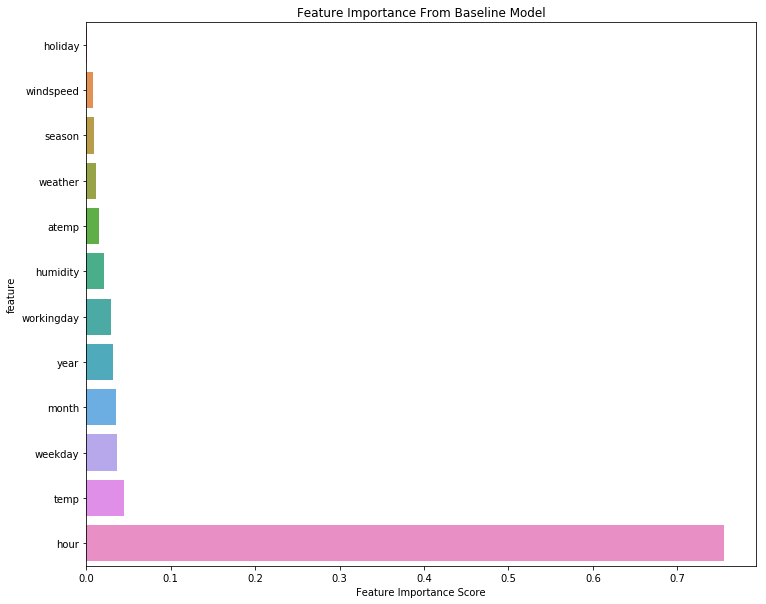

In [40]:
feat_imp = pd.DataFrame({'importance': baseline.feature_importances_})    
feat_imp['feature'] = X_train.drop(drops, axis=1).columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)

plt.figure(figsize=(12, 10))
sns.barplot(x=feat_imp['importance'], y=feat_imp.index)
plt.title('Feature Importance From Baseline Model')
plt.xlabel('Feature Importance Score')
plt.show()

The feature importances are calculated by finding the features that produce splits that minimize the MSE to increase the information gain - this comes from information theory. On top of this I want to also calculate their permuation importances, which works by randomly shuffling each of the features and calculating how much that affects the prediction/accuracy of the model. Using the <code>eli5</code> library you can easily implement this. 

In [41]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(baseline, random_state=1).fit(X_train.drop(drops, axis=1), log_ytrain)
eli5.show_weights(perm, feature_names = X_train.drop(drops, axis=1).columns.tolist())

Weight,Feature
1.5897 ± 0.0217,hour
0.0934 ± 0.0058,weekday
0.0808 ± 0.0014,year
0.0680 ± 0.0032,workingday
0.0577 ± 0.0015,month
0.0529 ± 0.0009,temp
0.0345 ± 0.0014,humidity
0.0185 ± 0.0008,atemp
0.0184 ± 0.0014,weather
0.0101 ± 0.0006,windspeed


### Findings:

- This model produced a training RMSLE of about 0.12 - and looking at the leaderboard this score is fairly good start. We still need to estimate the test error using the test set. 

- There is definitely an hourly trend in the dataset. And looking at the feature importance plot from the Random Forest model, you can see that hour had a large impact on the model. We can potentially bin this feature into high volume of rentals (high, average, low). More on that later.

- There is also an increase in rentals since 2011. One idea is to create a variable that includes this information by finding the time since 2011.

- Looking deeper into the dataset I found that <code>causual</code> and <code>registered</code> sum up to <code>count</code> - our target variable. Therefore, what I will do is build two seperate models - one predicting <code>causual</code> and another predicting <code>registered</code>. I will then add both of those predictions together to produce the final target vector - "count". Also, since the target variable contains outliers, I will predict the log transformation of <code>causual</code> and <code>registered</code> and before submission for scoring - reverse the logarithm. 

- Looking at the permutation importances, you can see that <code>hour, workingday, and year</code> are the top three most important features. 


# Feature Generation

Now I want to create more features based off my intial EDA and the baseline model. Using a bit of inspiration from ChristophM in his book "Interpretable Machine Learning" and AnalyticsVidhya (blog), I am going to create a number of features:

- Binning hour using splits from a decision tree
- Binning year into 8 quarters
- Creating a is_weekend feature
- Binning temperature using quartiles
- Binning windspeed using quartiles
- Creaing a days_since_start feature


#### blog:  https://www.analyticsvidhya.com/blog/2015/06/solution-kaggle-competition-bike-sharing-demand/

In [42]:
# function to create features

def generate_features(train, test):
    """
    This function generates the following features:
    - 'days_since_start'
    - 'temp_bin'
    - 'windspeed_bin'
    - 'hour_bin'
    - 'year_bin'
    - 'is_weekend'
    """
    
    # combined
    data = train.append(test)
    
    # days since data started being generated
    data['datetime2'] = pd.to_datetime(data.date, format="%Y-%m-%d")
    data['days_since_start'] = data['datetime2'] - data['datetime2'].min() 
    date_split = data['days_since_start'].astype(str).str.split()
    data['days_since_start'] = date_split.apply(lambda x: x[0]).astype(int)
    
    # binned temp
    data['temp_bin'] = pd.qcut(data['temp'], [0, .25, .5, .75, 1.], labels=False)
    
    # binned windspeed
    data['windspeed_bin'] = pd.qcut(data['windspeed'], [0, .25, .5, .75, 1.], labels=False)
    
    # binning hour using dt node splits
    data['hour'] = data.hour.astype(int)
    data['hour_bin'] = 0
    data['hour_bin'][data.hour < 9] = 1
    data['hour_bin'][data.hour >= 22] = 2
    data['hour_bin'][(data.hour > 9) & (data.hour < 18)] = 3
    data['hour_bin'][data.hour == 8] = 4
    data['hour_bin'][data.hour == 9] = 5
    data['hour_bin'][(data.hour == 20) | (data.hour == 21)] = 6
    data['hour_bin'][(data.hour == 19) | (data.hour == 18)] = 7
    
    # binning year into 8 quarters
    data['year_bin'] = 0
    data['month'] = data['month'].astype(int)
    data['year_bin'][data.year == '2011'] = 1
    data['year_bin'][(data.year == '2011') & (data.month > 3)] = 2
    data['year_bin'][(data.year == '2011') & (data.month > 6)] = 3
    data['year_bin'][(data.year == '2011') & (data.month > 9)] = 4
    data['year_bin'][data.year == '2012'] = 5
    data['year_bin'][(data.year == '2012') & (data.month > 3)] = 6
    data['year_bin'][(data.year == '2012') & (data.month > 6)] = 7
    data['year_bin'][(data.year == '2012') & (data.month > 9)] = 8
    
    # is weekend feature
    data['is_weekend'] = 0
    data['is_weekend'][(data.weekday == 0) | (data.weekday == 1)] = 1
    
    # free up space
    del data['datetime2']
    del date_split
    
    # training data
    train = data[pd.notnull(data['count'])].sort_values(by='datetime')
    # test data
    test = data[~pd.notnull(data['count'])].sort_values(by='datetime')
    
    del data
    
    return train, test
    
# verify    
tr, te = generate_features(tr, te)
tr.sample(5)


C:\ProgramData\Anaconda_apont\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda_apont\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda_apont\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda_apont\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,...,month,year,weekday,hour,days_since_start,temp_bin,windspeed_bin,hour_bin,year_bin,is_weekend
7017,31.820,0.0,6.0,2012-06-12 02:00:00,0,65,6.0,2,27.88,2,...,6,2012,1,2,528,3,1,1,6,1
16312,25.000,0.0,6.0,2012-09-13 04:00:00,0,83,6.0,3,21.32,1,...,9,2012,3,4,621,2,2,1,7,0
16468,15.910,29.0,235.0,2012-12-06 12:00:00,0,41,206.0,4,11.48,1,...,12,2012,3,12,705,0,0,3,8,0
7906,33.335,80.0,848.0,2012-08-15 18:00:00,0,51,768.0,3,30.34,1,...,8,2012,2,18,592,3,2,7,7,0
4457,22.725,2.0,16.0,2011-12-06 01:00:00,0,88,14.0,4,18.86,2,...,12,2011,1,1,339,1,3,1,4,1


In [43]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 15199 to 9572
Data columns (total 23 columns):
atemp               10886 non-null float64
casual              10886 non-null float64
count               10886 non-null float64
datetime            10886 non-null object
holiday             10886 non-null category
humidity            10886 non-null int64
registered          10886 non-null float64
season              10886 non-null category
temp                10886 non-null float64
weather             10886 non-null category
windspeed           10886 non-null float64
workingday          10886 non-null int64
date                10886 non-null object
month               10886 non-null int32
year                10886 non-null category
weekday             10886 non-null category
hour                10886 non-null int32
days_since_start    10886 non-null int32
temp_bin            10886 non-null int64
windspeed_bin       10886 non-null int64
hour_bin            10886 non-null int6

In [44]:
data.select_dtypes('category').columns.tolist()

['holiday', 'season', 'weather', 'month', 'year', 'weekday', 'hour']

In [45]:
# one hot encode for modeling
categoricals = ['weather']

def dummify(df, column):       
    df = pd.concat([df, pd.get_dummies(df[column], prefix=column, drop_first=True)],axis=1)
    df = df.drop([column], axis=1)
    return df

for column in categoricals:
    data = dummify(data, column)

data.head()

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,windspeed,workingday,date,month,year,weekday,hour,weather_2,weather_3,weather_4
15199,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,7.901980,0,2011-01-01,1,2011,5,0,0,0,0
15200,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,8.002480,0,2011-01-01,1,2011,5,1,0,0,0
15201,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,8.002480,0,2011-01-01,1,2011,5,2,0,0,0
15202,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,6.335967,0,2011-01-01,1,2011,5,3,0,0,0
15203,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,6.335967,0,2011-01-01,1,2011,5,4,0,0,0


In [46]:
# split again for modeling
train_final =  data[pd.notnull(data['count'])].sort_values(by='datetime')
test_final =  data[~pd.notnull(data['count'])].sort_values(by='datetime')

# dimensions should be equal to original train and test data
print(train_final.shape, test_final.shape, "Train and Test features")

# check
assert train_final.shape[0] == train_df.shape[0]
assert test_final.shape[0] == test_df.shape[0]

(10886, 19) (6493, 19) Train and Test features


In [47]:
tr.shape, te.shape

((10886, 23), (6493, 23))

# Modeling Strategy

As stated earlier, the count of registered and casual users together make up the target variable we are trying to predict. Therefore, I will create two seperate models: one predicting casual counts and the other predicting registered counts. After the predictions are made I will combine them back together for the final set of predictions.


In [48]:
tr.head()

,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,...,month,year,weekday,hour,days_since_start,temp_bin,windspeed_bin,hour_bin,year_bin,is_weekend
15199,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,...,1,2011,5,0,0,0,0,1,1,0
15200,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,...,1,2011,5,1,0,0,0,1,1,0
15201,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,...,1,2011,5,2,0,0,0,1,1,0
15202,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,...,1,2011,5,3,0,0,0,1,1,0
15203,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,...,1,2011,5,4,0,0,0,1,1,0


In [49]:
# features to drop for first model
drop_casual = ['datetime', 'date', 'casual', 'registered', 'count', 'temp']
# target
log_casual = np.log1p(tr['casual'])

# features for second model
drop_registered = ['datetime', 'date', 'casual', 'registered', 'count', 'temp']
# target
log_registered = np.log1p(tr['registered'])

# set up both models
model1 = RandomForestRegressor(n_estimators=500)
model2 = RandomForestRegressor(n_estimators=500)

# fit both
print("Training models..")
model1.fit(tr.drop(drop_casual, axis=1), log_casual)
model2.fit(tr.drop(drop_registered, axis=1), log_registered)

Training models..


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [50]:
# make predictions with test set
preds1 = model1.predict(te.drop(drop_casual, axis=1))
preds2 = model2.predict(te.drop(drop_registered, axis=1))

# add predictions to test set
te['log_casual'] = preds1
te['log_registered'] = preds2

# get inverse
te['casual'] = np.exp(te['log_casual']) - 1
te['registered'] = np.exp(te['log_registered']) - 1

# sum to get count
te['count'] = te['casual'] + te['registered']

# clear up space
del te['log_casual']
del te['log_registered']

# submission 
submission = pd.DataFrame({'datetime': te['datetime'],
                          'count': te['count']})

submission.head()

,datetime,count
9573,2011-01-20 00:00:00,11.344881
16512,2011-01-20 01:00:00,5.286264
16513,2011-01-20 02:00:00,2.495580
9574,2011-01-20 03:00:00,1.878390
9575,2011-01-20 04:00:00,1.813466


In [51]:
# lets see how the score is using the leader board
#submission.to_csv("RF1.csv", index=False)

After submitting these predictions to the leaderboard I recived a RMSLE of 0.45705. Relative to 1st place on the leaderboard (0.33756) our model can do better. A good practice is to visualize the distributions and compare them.

C:\ProgramData\Anaconda_apont\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


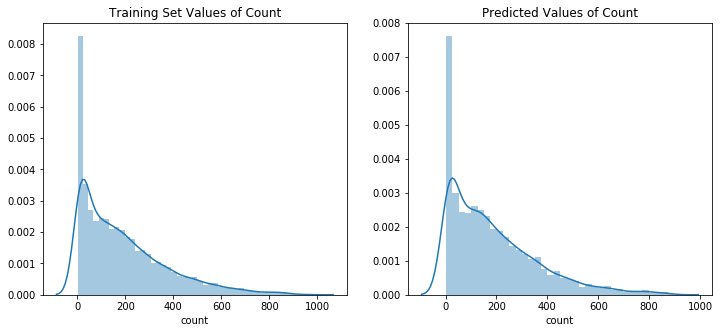

In [52]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(tr['count'], ax=ax1)
ax1.set_title("Training Set Values of Count")
sns.distplot(submission['count'], ax=ax2)
ax2.set_title("Predicted Values of Count")
plt.show()

C:\ProgramData\Anaconda_apont\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


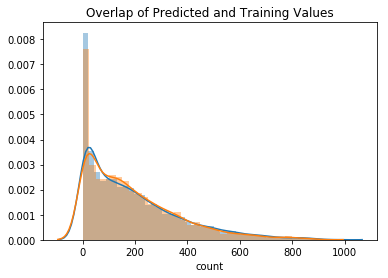

In [53]:
# lets see how they overlap
sns.distplot(tr['count'])
sns.distplot(submission['count'])
plt.title("Overlap of Predicted and Training Values")
plt.show()

### Findings:

As of now, my benchmark score is a RMSLE of 0.45705. Plotting the distributions you can see that the distribution of the predictions matches the distribution of the training target variable (count) fairly well. This serves as a nice visual check to see how the model is performing. Since we do not have the test set distribution available (the organizers did not provide that data) I used the training data under the assumption that the train and test sets were similar - this may be incorrect.

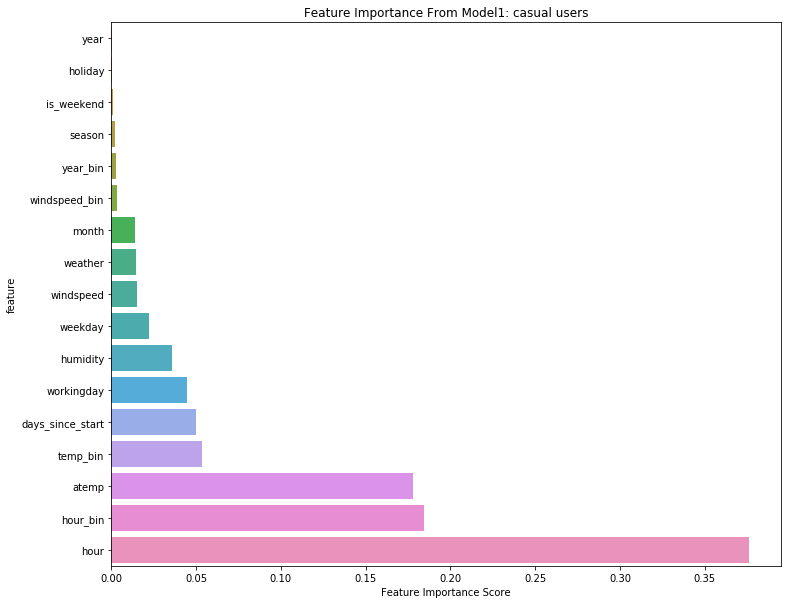

In [54]:
# using the casual model
feat_imp = pd.DataFrame({'importance': model1.feature_importances_})    
feat_imp['feature'] = tr.drop(drop_casual, axis=1).columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)

plt.figure(figsize=(12, 10))
sns.barplot(x=feat_imp['importance'], y=feat_imp.index)
plt.title('Feature Importance From Model1: casual users')
plt.xlabel('Feature Importance Score')
plt.show()

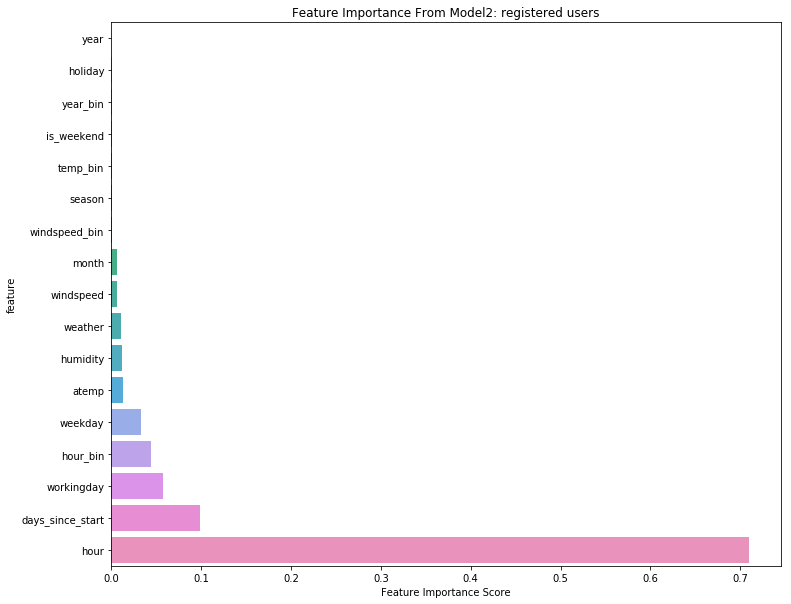

In [55]:
# using the registered model
feat_imp = pd.DataFrame({'importance': model2.feature_importances_})    
feat_imp['feature'] = tr.drop(drop_registered, axis=1).columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)

plt.figure(figsize=(12, 10))
sns.barplot(x=feat_imp['importance'], y=feat_imp.index)
plt.title('Feature Importance From Model2: registered users')
plt.xlabel('Feature Importance Score')
plt.show()

Looking at both of the feature importance plots we can see that time features are most important. Some of the weather features such as <code>atemp</code> also played an important role in predicting casual users but it was mostly time based features like <code>hour</code> or <code>days_since_start</code>. Also, its worth noting that the feature importance plots are different. 

Now let me try to select only the most important features using recursive feature elimination using the RFECV class in sklearn. You first have to set up a model and then input it into the algorithm. The result is a selector that ranks the features and selects the optimal number of features.

In [56]:
# feature selection
from sklearn.feature_selection import RFECV

estimator = RandomForestRegressor()

selector = RFECV(estimator, step=1, cv=3)

log_ytrain = np.log1p(tr['count'])

selector.fit(tr.drop(drop_casual, axis=1), log_ytrain)

C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\

C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\

RFECV(cv=3,
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [57]:
print('The optimal number of features is {}'.format(selector.n_features_))

features = [f for f,s in zip(tr.drop(drop_casual, axis=1), selector.support_) if s]

print('The selected features are:')
print ('{}'.format(features))

The optimal number of features is 10
The selected features are:
['atemp', 'humidity', 'weather', 'windspeed', 'workingday', 'month', 'weekday', 'hour', 'days_since_start', 'hour_bin']


After using RFECV it found that 12 features were optimal. Now while this helps with feature selection because it lets me know that I need to eliminate some of the features, I still want to understand why some features are more important than others. It appears as if time and the binned features play the biggest role and this makes sense with what I found earlier. What I can do now is use the selected features as input for another model. I will also submit these predictions to the scoreboard to see how well the model does. 

In [58]:
# reduced features
new_train = tr[features]

model = RandomForestRegressor(n_estimators=1000, max_depth=7)

model.fit(new_train, log_ytrain)

preds = model.predict(te[features])

te['count'] = np.exp(preds) - 1

# submission 
submission2 = pd.DataFrame({'datetime': te['datetime'],
                          'count': te['count']})

submission2.head()

,datetime,count
9573,2011-01-20 00:00:00,10.342324
16512,2011-01-20 01:00:00,4.649319
16513,2011-01-20 02:00:00,2.833508
9574,2011-01-20 03:00:00,2.357577
9575,2011-01-20 04:00:00,2.332237


In [59]:
#submission2.to_csv("RF2.csv", index=False)

After submitting these predictions I recieved a score of 0.58536 - which tells me that the model did much better with all of the features. Now the next step is to find the optimal model through model selection.

# Model Selection

I like to start by iterating through different types of algorithms looking for the most promising one. I decided here to iterate through linear and tree-based models and use 3-fold cross-validation to find their negative mean squared error. At the end of the training I took their average negative mean squared error. 

In [60]:
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

models = [LinearRegression(),
          Ridge(),
          HuberRegressor(),
          ElasticNetCV(),
          DecisionTreeRegressor(), 
          ExtraTreesRegressor(),
          GradientBoostingRegressor(),
          RandomForestRegressor(),
          BaggingRegressor()]

def test_models(model):
    """
    This function gets the cross-validated neg_mean_squared_error and averages the result.
    """
    predicted = cross_val_score(model, tr.drop(drop_casual, axis=1), log_ytrain, cv=3, scoring='neg_mean_squared_error')
    print(predicted.mean())
    
for model in models:
    test_models(model)

-0.937736025033774
-0.9376642476744675
-0.9424667846198073


C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


-0.9390705173716443
-0.4186077463749496


C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


-0.22676895745758383
-0.2614278255730433


C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


-0.2628921939449131
-0.25581992403181436


Best results were found using the ExtraTreesRegressor. Let me now build another model making predictions on the test set. 

In [61]:
tr.drop(drop_casual, axis=1).shape, te.drop(drop_casual, axis=1).shape

((10886, 17), (6493, 17))

In [62]:
# extra trees model
model =  ExtraTreesRegressor()

# train
model.fit(tr.drop(drop_casual, axis=1), log_ytrain)

# preds with test set
preds = model.predict(te.drop(drop_casual, axis=1))

# replace 
te['count'] = np.exp(preds) - 1

# submission 
submission3 = pd.DataFrame({'datetime': te['datetime'],
                          'count': te['count']})

submission3.head()

C:\ProgramData\Anaconda_apont\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,datetime,count
9573,2011-01-20 00:00:00,7.167649
16512,2011-01-20 01:00:00,4.492803
16513,2011-01-20 02:00:00,2.579789
9574,2011-01-20 03:00:00,2.758480
9575,2011-01-20 04:00:00,3.514402


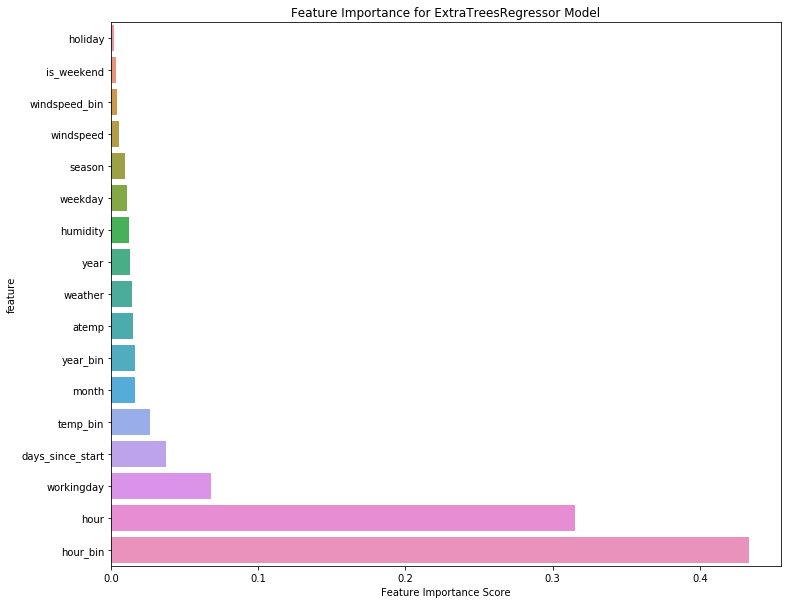

In [73]:
# using the casual model
feat_imp = pd.DataFrame({'importance': model.feature_importances_})    
feat_imp['feature'] = tr.drop(drop_casual, axis=1).columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)

plt.figure(figsize=(12, 10))
sns.barplot(x=feat_imp['importance'], y=feat_imp.index)
plt.title('Feature Importance for ExtraTreesRegressor Model')
plt.xlabel('Feature Importance Score')
plt.show()

In [63]:
# submit for predictions
#submission3.to_csv("ExtraTrees1.csv", index=False)

Using the ExtraTrees regressor on the test set I recieved a score of 0.47159 - not better than our benchmark of 0.45705. So I'll stick with the RandomForestRegressor but will try to fine tune the hyperparameters.

# Hyperparameter Tuning

In order to quickly test out various parameters I will use the sklearn's RandomizedSearchCV. Due to its greedy approach it often yields sub-optimal results but it nevertheless can be very useful in finding good hyperparameters.

In [75]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Rf model
rf = RandomForestRegressor()

# hyperparameter space
params = {'n_estimators': np.arange(10, 2000, 50),
         'max_depth': np.arange(1, 30),
         'min_samples_split': np.arange(0.1, 1.0, 10),
         'min_samples_leaf': np.arange(0.1, 0.5, 5),
         'max_features': list(range(1,tr.drop(drop_casual, axis=1).shape[1]))}

# 3-fold cross validation
# brute force search
#grid = GridSearchCV(rf, params, cv=3)
grid = RandomizedSearchCV(rf, params, cv=3) 

# fit
grid.fit(tr.drop(drop_casual, axis=1), log_ytrain)

# best params
print(grid.best_params_)
print(grid.best_estimator_, 'Best estimator')

{'n_estimators': 810, 'min_samples_split': 0.1, 'min_samples_leaf': 0.1, 'max_features': 14, 'max_depth': 13}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features=14, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=0.1,
           min_samples_split=0.1, min_weight_fraction_leaf=0.0,
           n_estimators=810, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False) Best estimator


# Findings

Looks like the randomized grid search found that more estimators and deeper trees resulted in better scores. But it also used a small amount of features per split and per leaf. More estimators and deeper trees usually reduce bias but increase variance; more samples per split, and thereby their leaves (terminal nodes), reduce variance but also increase bias. Keeping in mind that RandomizedGridSearchCV does not find the optimal solution, I'll manually change some of the hyperparameters.

In [86]:
# best estimator
final_model = RandomForestRegressor(n_estimators=1000, max_depth=10)

# train
final_model.fit(tr.drop(drop_casual, axis=1), log_ytrain)

# preds with test set
final_preds = final_model.predict(te.drop(drop_casual, axis=1))

# transform
transformed_counts = np.exp(final_preds) - 1

# submission 
submission = pd.DataFrame({'datetime': te['datetime'],
                          'count': transformed_counts})

submission.head()

,datetime,count
9573,2011-01-20 00:00:00,10.874664
16512,2011-01-20 01:00:00,4.877115
16513,2011-01-20 02:00:00,2.493235
9574,2011-01-20 03:00:00,2.300718
9575,2011-01-20 04:00:00,2.169735


In [88]:
submission.to_csv("final_bike_regression", index=False)

The RMSLE was 0.46890 for this submission.

# Conclusion

The best model ended up being the RandomForestRegressor with 500 estimators.